Кодировка: windows-1251
Порог: 1.0%; время: 3.5631 сек; наборов: 261
Порог: 3.0%; время: 0.7661 сек; наборов: 55
Порог: 5.0%; время: 0.3214 сек; наборов: 28
Порог: 10.0%; время: 0.0686 сек; наборов: 7
Порог: 15.0%; время: 0.0396 сек; наборов: 5


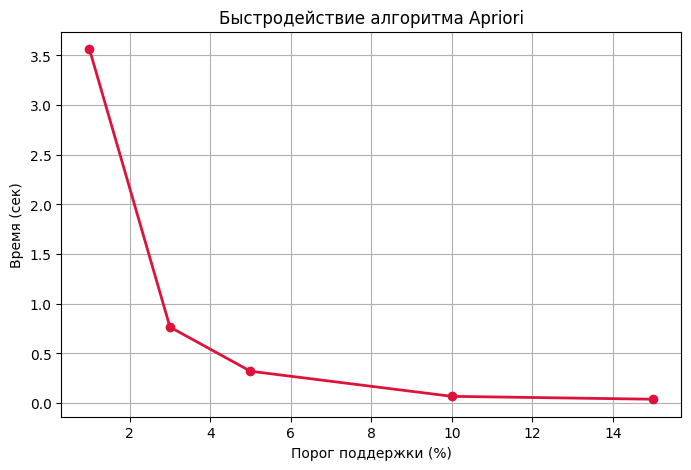

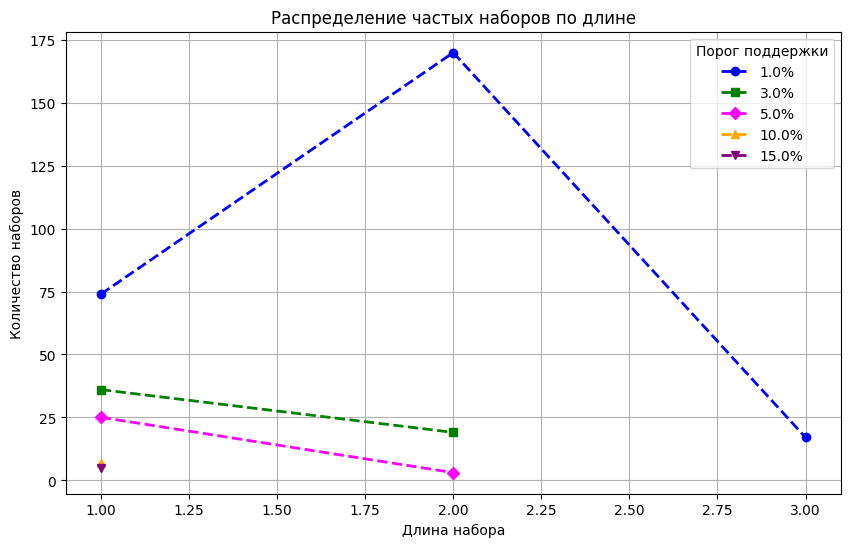

In [ ]:
import csv
import time
import itertools
import collections
import matplotlib.pyplot as plt
import chardet

# Функция для определения кодировки файла
def detect_file_encoding(path):
    with open(path, 'rb') as f:
        sample = f.read(10000)
    encoding = chardet.detect(sample)['encoding']
    print("Кодировка:", encoding)
    return encoding

# Загрузка транзакций из CSV-файла
def load_transactions(path):
    encoding = detect_file_encoding(path)  # Определяем кодировку
    transactions = []
    with open(path, 'r', encoding=encoding) as f:
        reader = csv.reader(f)
        for row in reader:
            # Убираем пробелы и пустые строки, превращаем строку в множество
            items = {x.strip() for x in row if x.strip()}
            if items:
                transactions.append(items)  # Добавляем транзакцию в список
    return transactions

# Вычисление поддержки (support) для одного набора товаров
def compute_support(itemset, transactions):
    # Поддержка = доля транзакций, содержащих этот набор
    return sum(1 for t in transactions if itemset.issubset(t)) / len(transactions)

# Реализация алгоритма Apriori
def apriori_algorithm(transactions, min_support):
    freq_itemsets = {}  # словарь, в котором будут храниться все частые наборы и их поддержка
    total = len(transactions)  # Количество транзакций
    counter = collections.Counter()  # Счётчик одиночных товаров

    # Первый проход: считаем частоту каждого отдельного товара
    for t in transactions:
        for item in t:
            counter[frozenset([item])] += 1  # frozenset нужен, чтобы использовать множества как ключи

    # Выбираем частые одиночные товары
    level1 = {fs: cnt / total for fs, cnt in counter.items() if cnt / total >= min_support}
    freq_itemsets.update(level1)  # Добавляем в общую таблицу частых наборов

    current = set(level1.keys())  # Текущий уровень (частые наборы длины 1)
    k = 2  # Начинаем строить наборы длины 2

    while current:
        candidates = set()

        # Генерируем кандидатов из всех пар частых наборов предыдущего уровня
        for a, b in itertools.combinations(current, 2):
            cand = a | b  # Объединяем два набора
            # Добавляем кандидата, если все его поднаборы длины k-1 тоже частые
            if len(cand) == k and all(frozenset(sub) in current for sub in itertools.combinations(cand, k - 1)):
                candidates.add(cand)

        # Считаем поддержку для каждого кандидата
        counts = collections.Counter()
        for t in transactions:
            for cand in candidates:
                if cand.issubset(t):
                    counts[cand] += 1

        # Отбираем только те наборы, у которых поддержка >= min_support
        next_level = {fs: cnt / total for fs, cnt in counts.items() if cnt / total >= min_support}
        if not next_level:
            break  # Если нет частых наборов, заканчиваем
        freq_itemsets.update(next_level)  # Добавляем в общий список
        current = set(next_level.keys())  # Новый уровень
        k += 1  # Увеличиваем размер наборов

    return freq_itemsets  # Возвращаем все частые наборы

# Сортировка результатов по убыванию поддержки или лексикографически
def order_results(freq_itemsets, mode='support'):
    if mode == 'support':
        return sorted(freq_itemsets.items(), key=lambda x: (-x[1], sorted(x[0])))
    elif mode == 'lex':
        return sorted(freq_itemsets.items(), key=lambda x: (sorted(x[0]), -x[1]))
    return list(freq_itemsets.items())

# Запуск экспериментов для разных уровней поддержки
def execute_experiments(transactions, thresholds, order_mode='support'):
    runtime_results = []  # Время выполнения для каждого уровня поддержки
    length_stats = {}  # Статистика по длине наборов

    for thresh in thresholds:
        start = time.time()
        freq_sets = apriori_algorithm(transactions, thresh)  # Запуск алгоритма
        elapsed = time.time() - start  # Сколько времени заняло

        runtime_results.append(elapsed)
        # Считаем, сколько наборов какой длины нашлось
        lengths = collections.Counter(len(item) for item in freq_sets.keys())
        length_stats[thresh] = dict(lengths)

        # Сортируем и печатаем информацию
        ordered = order_results(freq_sets, mode=order_mode)
        print(f"Порог: {thresh*100:.1f}%; время: {elapsed:.4f} сек; наборов: {len(ordered)}")

    return runtime_results, length_stats

# Основной запуск программы
if __name__ == "__main__":
    data_path = "/content/baskets.csv"  # Путь к файлу с транзакциями
    transactions_data = load_transactions(data_path)  # Загружаем данные

    support_levels = [0.01, 0.03, 0.05, 0.10, 0.15]  # Порог поддержки
    runtimes, length_distribution = execute_experiments(transactions_data, support_levels, order_mode='support')

    # Построение графика: зависимость времени работы от порога поддержки
    plt.figure(figsize=(8, 5))
    plt.plot([s*100 for s in support_levels], runtimes, marker='o', color='crimson', linestyle='-', linewidth=2)
    plt.xlabel("Порог поддержки (%)")
    plt.ylabel("Время (сек)")
    plt.title("Быстродействие алгоритма Apriori")
    plt.grid(True)
    plt.savefig("time_vs_support.png")
    plt.show()

    # Построение графика: распределение частых наборов по длине
    plt.figure(figsize=(10, 6))
    markers = ['o', 's', 'D', '^', 'v']
    colors = ['blue', 'green', 'magenta', 'orange', 'purple']
    for i, s in enumerate(support_levels):
        xs = sorted(length_distribution[s].keys())
        ys = [length_distribution[s].get(x, 0) for x in xs]
        plt.plot(xs, ys, marker=markers[i % len(markers)], color=colors[i % len(colors)],
                 label=f'{s*100:.1f}%', linestyle='--', linewidth=2)
    plt.xlabel("Длина набора")
    plt.ylabel("Количество наборов")
    plt.title("Распределение частых наборов по длине")
    plt.legend(title="Порог поддержки")
    plt.grid(True)
    plt.savefig("itemset_distribution.png")
    plt.show()


Определённая кодировка файла: windows-1251
Порог поддержки: 1.0%; время выполнения: 1.9942 сек; найдено наборов: 261
Порог поддержки: 3.0%; время выполнения: 0.4076 сек; найдено наборов: 55
Порог поддержки: 5.0%; время выполнения: 0.1873 сек; найдено наборов: 28
Порог поддержки: 10.0%; время выполнения: 0.0336 сек; найдено наборов: 7
Порог поддержки: 15.0%; время выполнения: 0.0252 сек; найдено наборов: 5


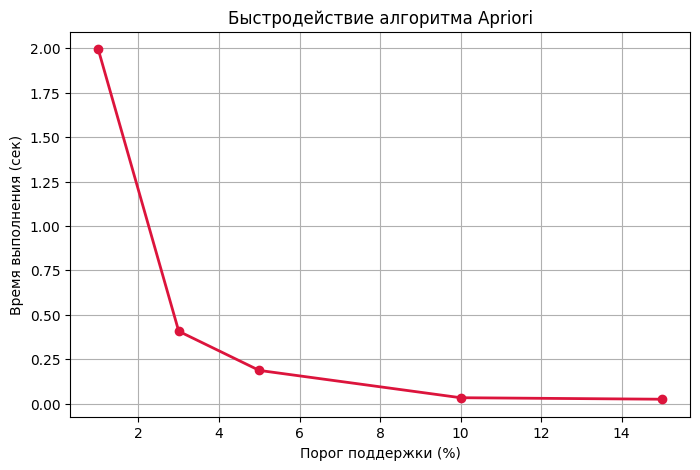

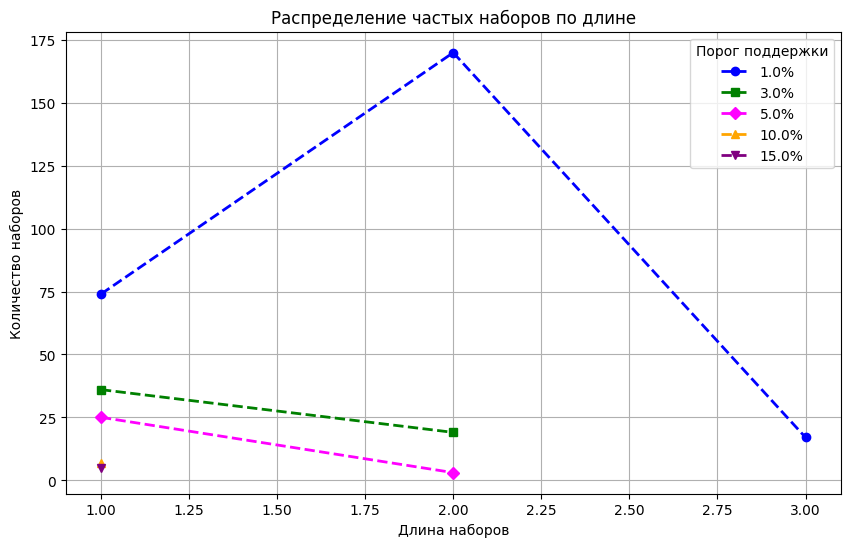


Найдено 55 частых наборов при пороге поддержки 3.0%
Порог достоверности: 5%; время поиска правил: 0.0001 сек; найдено правил: 38
Порог достоверности: 10%; время поиска правил: 0.0000 сек; найдено правил: 38
Порог достоверности: 15%; время поиска правил: 0.0000 сек; найдено правил: 34
Порог достоверности: 20%; время поиска правил: 0.0000 сек; найдено правил: 26
Порог достоверности: 25%; время поиска правил: 0.0000 сек; найдено правил: 10


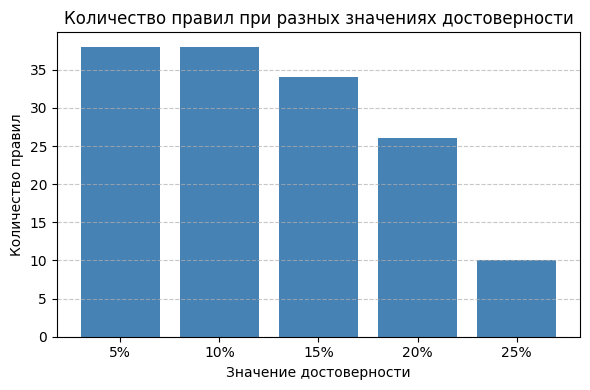

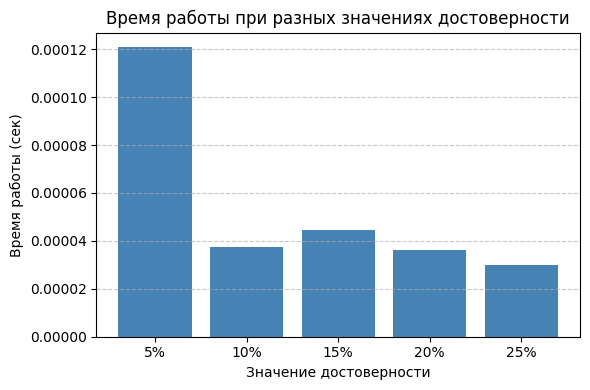


Правила (достоверность 10%) с суммарным числом объектов ≤ 7
        Antecedent         Consequent  Support  Confidence
          макароны   минеральная вода   0.0612      0.3255
  минеральная вода           макароны   0.0612      0.2567
  минеральная вода            шоколад   0.0527      0.2209
           шоколад   минеральная вода   0.0527      0.3214
  минеральная вода               яйца   0.0509      0.2136
              яйца   минеральная вода   0.0509      0.2834
  минеральная вода             молоко   0.0480      0.2013
            молоко   минеральная вода   0.0480      0.3704
      говяжий фарш   минеральная вода   0.0409      0.4166
  минеральная вода       говяжий фарш   0.0409      0.1717
          макароны            шоколад   0.0408      0.2170
           шоколад           макароны   0.0408      0.2490
      говяжий фарш           макароны   0.0403      0.4098
          макароны       говяжий фарш   0.0403      0.2142
          макароны               яйца   0.0387      0.

In [2]:
import csv
import time
import itertools
import collections
import matplotlib.pyplot as plt
import chardet
import pandas as pd  # для табличного вывода

# Функция для определения кодировки файла
def detect_file_encoding(path):
    with open(path, 'rb') as f:
        sample = f.read(10000)
    encoding = chardet.detect(sample)['encoding']
    print("Кодировка:", encoding)
    return encoding

# Загрузка транзакций из CSV-файла
def load_transactions(path):
    encoding = detect_file_encoding(path)  # Определяем кодировку
    transactions = []
    with open(path, 'r', encoding=encoding) as f:
        reader = csv.reader(f)
        for row in reader:
            # Убираем пробелы и пустые строки, превращаем строку в множество
            items = {x.strip() for x in row if x.strip()}
            if items:
                transactions.append(items)  # Добавляем транзакцию в список
    return transactions

# Вычисление поддержки (support) для одного набора товаров
def compute_support(itemset, transactions):
    # Поддержка = доля транзакций, содержащих этот набор
    return sum(1 for t in transactions if itemset.issubset(t)) / len(transactions)


# Реализация алгоритма Apriori
def apriori_algorithm(transactions, min_support):
    freq_itemsets = {}  # словарь, в котором будут храниться все частые наборы и их поддержка
    total = len(transactions)  # Количество транзакций
    counter = collections.Counter()  # Счётчик одиночных товаров

    # Первый проход: считаем частоту каждого отдельного товара
    for t in transactions:
        for item in t:
            counter[frozenset([item])] += 1  # frozenset нужен, чтобы использовать множества как ключи

    # Выбираем частые одиночные товары
    level1 = {fs: cnt / total for fs, cnt in counter.items() if cnt / total >= min_support}
    freq_itemsets.update(level1)  # Добавляем в общую таблицу частых наборов

    current = set(level1.keys())  # Текущий уровень (частые наборы длины 1)
    k = 2  # Начинаем строить наборы длины 2

    while current:
        candidates = set()

        # Генерируем кандидатов из всех пар частых наборов предыдущего уровня
        for a, b in itertools.combinations(current, 2):
            cand = a | b  # Объединяем два набора
            # Добавляем кандидата, если все его поднаборы длины k-1 тоже частые
            if len(cand) == k and all(frozenset(sub) in current for sub in itertools.combinations(cand, k - 1)):
                candidates.add(cand)

        # Считаем поддержку для каждого кандидата
        counts = collections.Counter()
        for t in transactions:
            for cand in candidates:
                if cand.issubset(t):
                    counts[cand] += 1

        # Отбираем только те наборы, у которых поддержка >= min_support
        next_level = {fs: cnt / total for fs, cnt in counts.items() if cnt / total >= min_support}
        if not next_level:
            break  # Если нет частых наборов, заканчиваем
        freq_itemsets.update(next_level)  # Добавляем в общий список
        current = set(next_level.keys())  # Новый уровень
        k += 1  # Увеличиваем размер наборов

    return freq_itemsets  # Возвращаем все частые наборы


# Сортировка результатов по убыванию поддержки или лексикографически
def order_results(freq_itemsets, mode='support'):
    if mode == 'support':
        return sorted(freq_itemsets.items(), key=lambda x: (-x[1], sorted(x[0])))
    elif mode == 'lex':
        return sorted(freq_itemsets.items(), key=lambda x: (sorted(x[0]), -x[1]))
    return list(freq_itemsets.items())

# Запуск экспериментов для разных уровней поддержки
def execute_experiments(transactions, thresholds, order_mode='support'):
    runtime_results = []  # Время выполнения для каждого уровня поддержки
    length_stats = {}  # Статистика по длине наборов

    for thresh in thresholds:
        start = time.time()
        freq_sets = apriori_algorithm(transactions, thresh)  # Запуск алгоритма
        elapsed = time.time() - start  # Сколько времени заняло

        runtime_results.append(elapsed)
        # Считаем, сколько наборов какой длины нашлось
        lengths = collections.Counter(len(item) for item in freq_sets.keys())
        length_stats[thresh] = dict(lengths)

        # Сортируем и печатаем информацию
        ordered = order_results(freq_sets, mode=order_mode)
        print(f"Порог: {thresh*100:.1f}%; время: {elapsed:.4f} сек; наборов: {len(ordered)}")

    return runtime_results, length_stats

# ==============================
# Генерация ассоциативных правил
# ==============================

def generate_rules(frequent_itemsets, min_confidence):
    """
    Для каждого частого набора X (размером >=2) генерируются правила:
    для каждого непустого подмножества A ⊂ X, B = X \ A.
    Правило A → B имеет поддержку sup(X) и достоверность = sup(X)/sup(A).
    """
    rules = []  # Здесь будем хранить все найденные правила
    for itemset in frequent_itemsets:
        if len(itemset) < 2:
            continue  # Пропускаем наборы из 1 товара
        sup_itemset = frequent_itemsets[itemset]  # Поддержка набора
        # Перебираем все непустые подмножества набора
        for i in range(1, len(itemset)):
            for antecedent in itertools.combinations(itemset, i):  # Все подмножества размера i
                antecedent = frozenset(antecedent)  # А
                consequent = itemset - antecedent  # B
                if not consequent:
                    continue  # Пропускаем, если consequent пустой (некорректное правило)
                sup_antecedent = frequent_itemsets.get(antecedent, 0)  # Находим поддержку A
                if sup_antecedent > 0:
                    confidence = sup_itemset / sup_antecedent # Считаем достоверность: sup(X) / sup(A)
                    if confidence >= min_confidence:# Если достоверность выше порога — добавляем правило
                        rules.append((antecedent, consequent, sup_itemset, confidence))
    return rules

def order_rules(rules, mode='support'):
    if mode == 'support':
        ordered = sorted(rules, key=lambda rule: (-rule[2], sorted(rule[0]), sorted(rule[1])))
    elif mode == 'lex':
        ordered = sorted(rules, key=lambda rule: (sorted(rule[0]), sorted(rule[1]), -rule[2]))
    else:
        ordered = list(rules)
    return ordered


# Эксперименты по порогу достоверности

def experiment_association_rules(transactions, support_threshold, confidence_thresholds, order_mode='support'):
    # Сначала ищем частые наборы при фиксированном пороге поддержки
    frequent_itemsets = apriori_algorithm(transactions, support_threshold)
    print(f"\nНайдено {len(frequent_itemsets)} частых наборов при пороге поддержки {support_threshold*100:.1f}%")

    runtimes = [] # Время работы для каждого порога достоверности
    rules_counts = [] # Сколько правил найдено для каждого порога достоверности
    rules_by_conf = {} # Сами правила, сгруппированные по порогу достоверности

    for conf_thresh in confidence_thresholds: # Перебираем все заданные значения порога достоверности
        start = time.time()
        rules = generate_rules(frequent_itemsets, conf_thresh)
        elapsed = time.time() - start
        # Сортируем правила
        rules = order_rules(rules, mode=order_mode)
        runtimes.append(elapsed)
        rules_counts.append(len(rules))
        rules_by_conf[conf_thresh] = rules
        print(f"Порог достоверности: {conf_thresh*100:.0f}%; время поиска правил: {elapsed:.4f} сек; найдено правил: {len(rules)}")

    return runtimes, rules_counts, rules_by_conf

# Функция для табличного вывода правил с использованием pandas

def print_rules_table(rules, header="Ассоциативные правила"):
    """
    Выводит правила в виде таблицы (DataFrame) с колонками:
    Antecedent, Consequent, Support, Confidence.
    """
    if not rules:
        print(f"\n{header}\nНет правил для отображения.")
        return

    df = pd.DataFrame(rules, columns=["Antecedent", "Consequent", "Support", "Confidence"])
    # Преобразуем множества в строки для удобства отображения
    df["Antecedent"] = df["Antecedent"].apply(lambda x: ", ".join(sorted(x)))
    df["Consequent"] = df["Consequent"].apply(lambda x: ", ".join(sorted(x)))
    df["Support"] = df["Support"].round(4)
    df["Confidence"] = df["Confidence"].round(4)

    print("\n" + header)
    print(df.to_string(index=False))

# Основной блок программы

if __name__ == "__main__":
    # 1) Загрузка данных
    data_path = "/content/baskets.csv"  # Укажите путь к вашему CSV-файлу
    transactions_data = load_transactions(data_path)

    # 2) Эксперименты с разными порогами поддержки
    support_levels = [0.01, 0.03, 0.05, 0.10, 0.15]
    runtimes, length_distribution = execute_experiments(transactions_data, support_levels, order_mode='support')

    # График 1: зависимость времени выполнения от порога поддержки
    plt.figure(figsize=(8, 5))
    plt.plot([level * 100 for level in support_levels], runtimes,
             marker='o', color='crimson', linestyle='-', linewidth=2)
    plt.xlabel("Порог поддержки (%)")
    plt.ylabel("Время выполнения (сек)")
    plt.title("Быстродействие алгоритма Apriori")
    plt.grid(True)
    plt.savefig("time_vs_support.png")
    plt.show()

    # График 2: распределение частых наборов по длине
    plt.figure(figsize=(10, 6))
    markers = ['o', 's', 'D', '^', 'v']
    colors = ['blue', 'green', 'magenta', 'orange', 'purple']
    for idx, level in enumerate(support_levels):
        x_lengths = sorted(length_distribution[level].keys())
        y_counts = [length_distribution[level].get(x, 0) for x in x_lengths]
        plt.plot(x_lengths, y_counts, marker=markers[idx % len(markers)],
                 color=colors[idx % len(colors)], label=f'{level*100:.1f}%',
                 linestyle='--', linewidth=2)
    plt.xlabel("Длина наборов")
    plt.ylabel("Количество наборов")
    plt.title("Распределение частых наборов по длине")
    plt.legend(title="Порог поддержки")
    plt.grid(True)
    plt.savefig("itemset_distribution.png")
    plt.show()

    # 3) Эксперименты с порогом достоверности (BAR CHARTS)
    #    Фиксируем порог поддержки, варьируем достоверность: [5%, 10%, 15%, 20%, 25%]
    fixed_support = 0.03  # Пример: 3% (можно изменить по необходимости)
    confidence_thresholds = [0.05, 0.10, 0.15, 0.20, 0.25]

    runtimes_rules, rules_counts, rules_by_conf = experiment_association_rules(
        transactions_data, fixed_support, confidence_thresholds, order_mode='support'
    )

    # График 3: Количество правил (BAR CHART)
    plt.figure(figsize=(6, 4))
    x_labels = [str(int(ct * 100)) + '%' for ct in confidence_thresholds]
    plt.bar(x_labels, rules_counts, color='steelblue')
    plt.xlabel("Значение достоверности")
    plt.ylabel("Количество правил")
    plt.title("Количество правил при разных значениях достоверности")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("rules_count_vs_confidence_bar.png")
    plt.show()

    # График 4: Время работы (BAR CHART)
    plt.figure(figsize=(6, 4))
    plt.bar(x_labels, runtimes_rules, color='steelblue')
    plt.xlabel("Значение достоверности")
    plt.ylabel("Время работы (сек)")
    plt.title("Время работы при разных значениях достоверности")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("rules_runtime_vs_confidence_bar.png")
    plt.show()

    # 4) Вывод правил, где антецедент + консеквент ≤ 7 объектов
    selected_confidence = 0.10  # Например, выбрали 10%
    final_rules = rules_by_conf.get(selected_confidence, [])

    filtered_rules = []
    for rule in final_rules:
        antecedent, consequent, support, confidence = rule
        if (len(antecedent) + len(consequent)) <= 7:
            filtered_rules.append(rule)

    # Табличный вывод правил
    print_rules_table(filtered_rules, header=f"Правила (достоверность {selected_confidence*100:.0f}%) с суммарным числом объектов ≤ 7")

    # 5) В отчёте можно включить:
    #   - формулировку задания,
    #   - ссылку на репозиторий,
    #   - рисунки с результатами (сохранённые PNG-файлы),
    #   - интерпретацию полученных правил.

